Epoch 1/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - loss: 0.6479 - val_loss: 0.5844
Epoch 2/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 0.6022 - val_loss: 0.5844
Epoch 3/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - loss: 0.6028 - val_loss: 0.5844
Epoch 4/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - loss: 0.6096 - val_loss: 0.5844
Epoch 5/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - loss: 0.6112 - val_loss: 0.5844
Epoch 6/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - loss: 0.6049 - val_loss: 0.5844
Epoch 7/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - loss: 0.6132 - val_loss: 0.5844
Epoch 8/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - loss: 0.6009 - val_loss: 0.5844
Epoch 9/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 566s 1s/step - loss: 0.6032 - val_loss: 0.5844
Epoch 10/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - loss: 0.6006 - val_loss: 0.5844
Epoch 11/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 0.6058 - val_loss: 0.5844
Epoch 12/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 

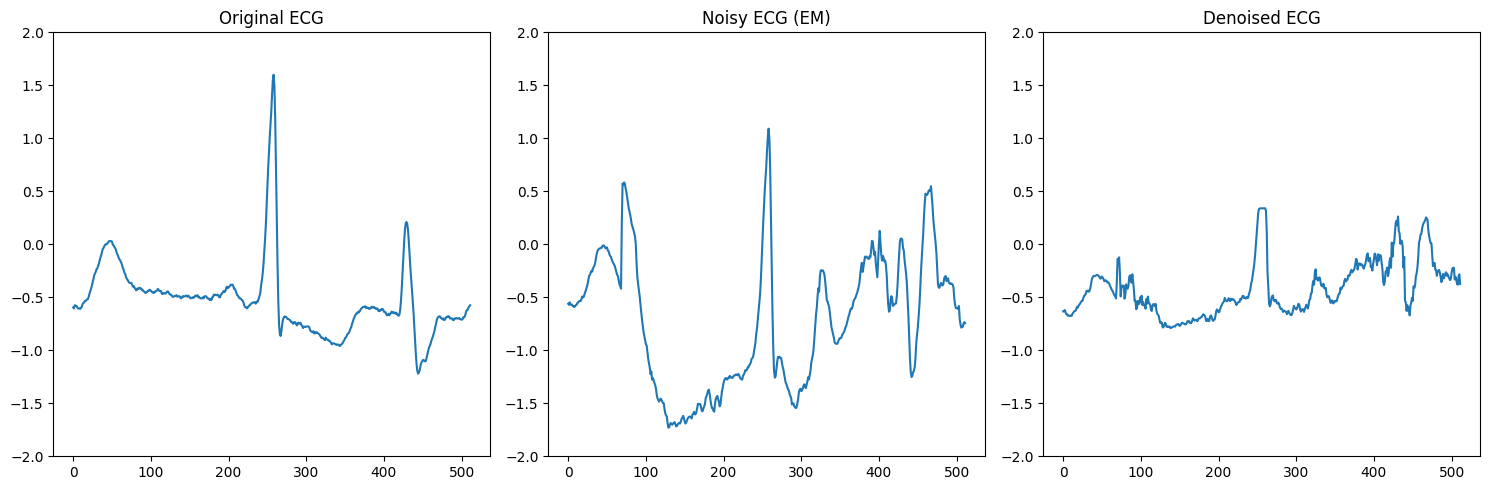

114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


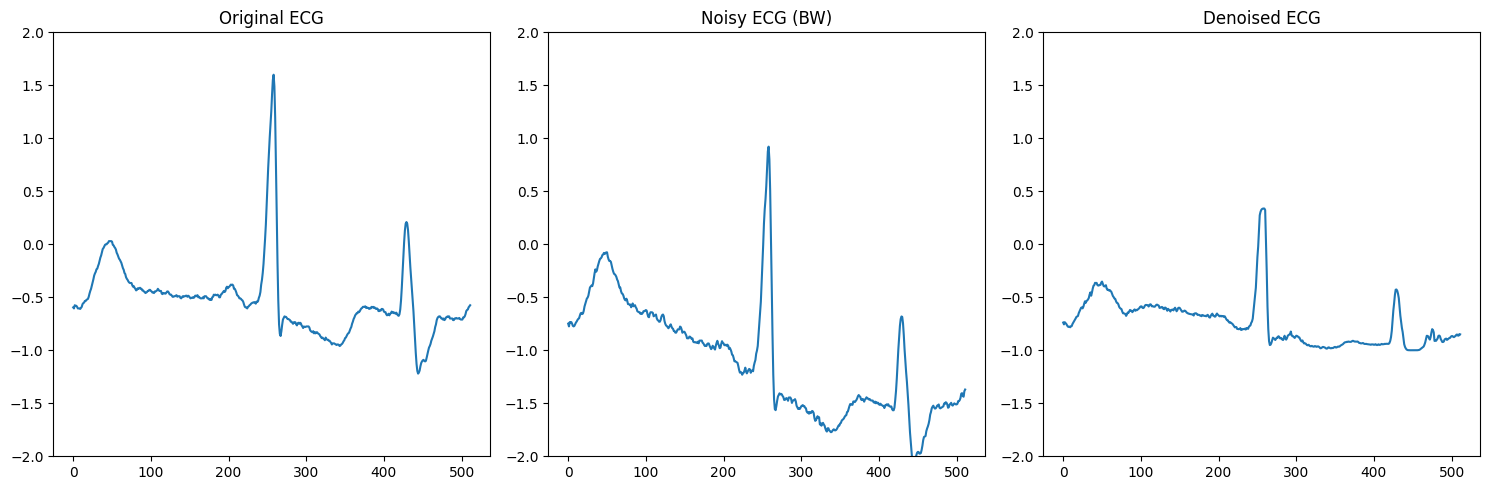

114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


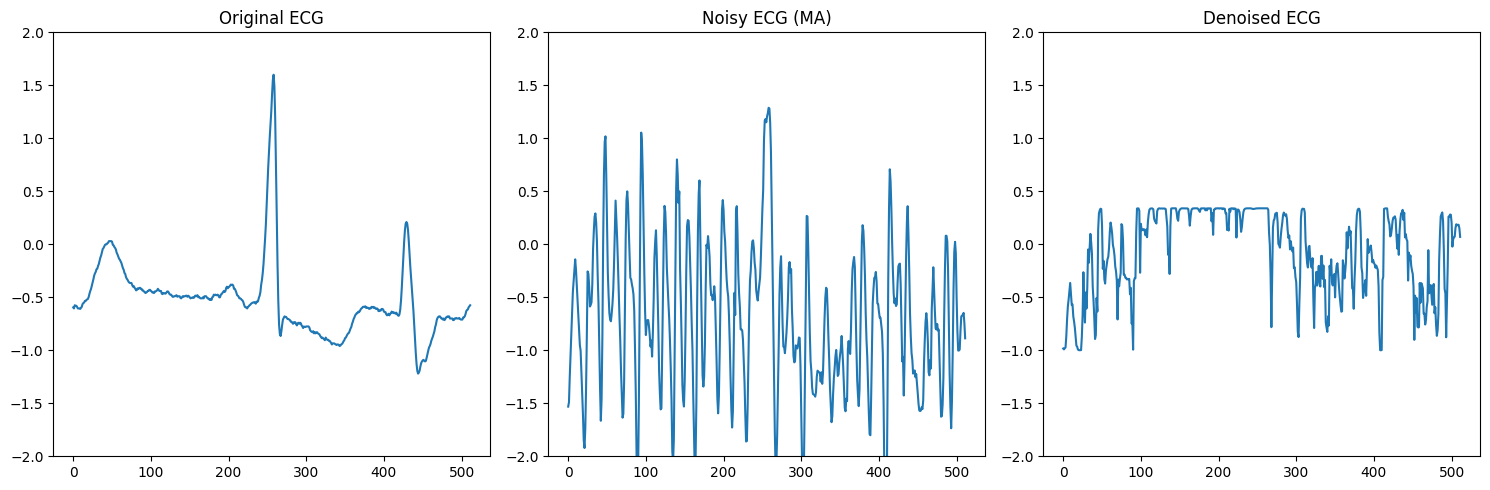

114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


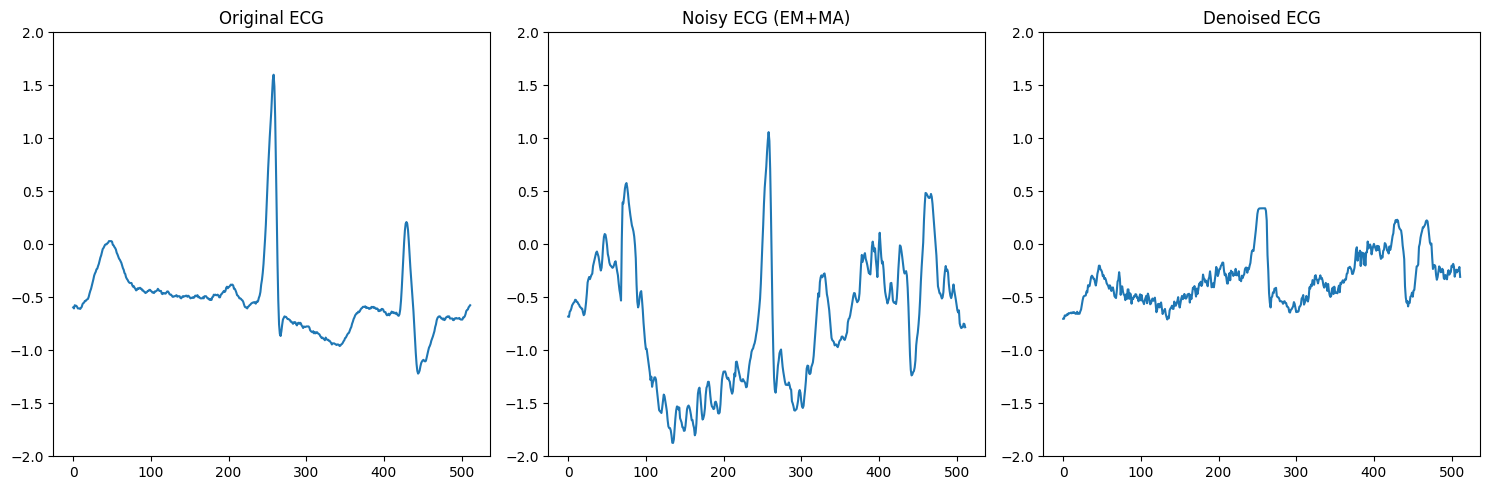

114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


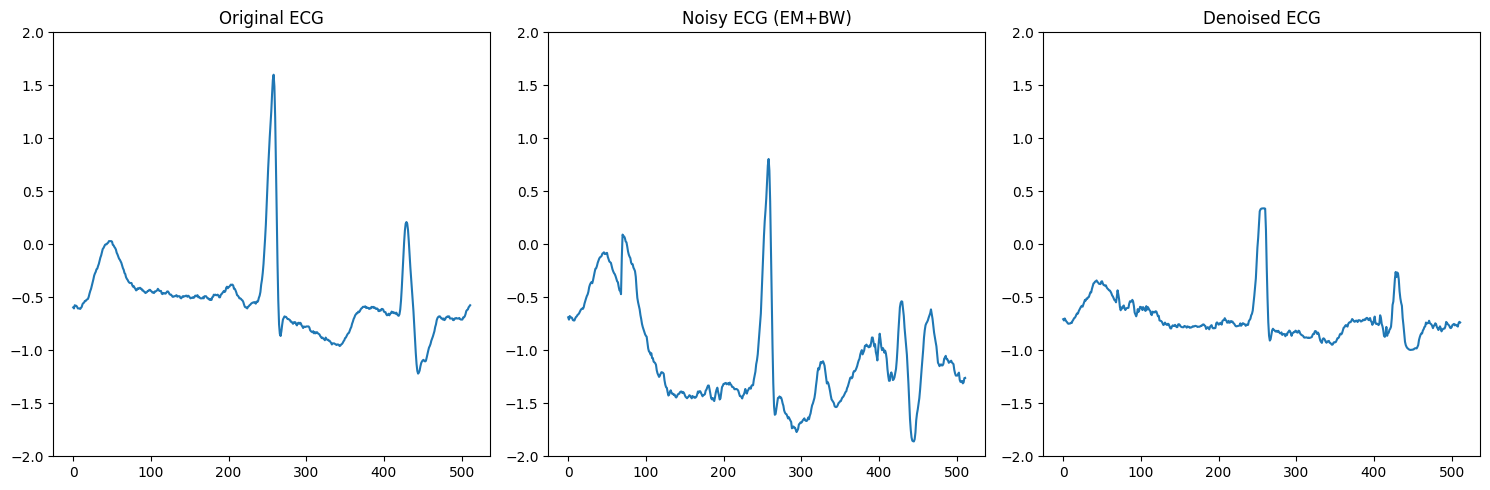

114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


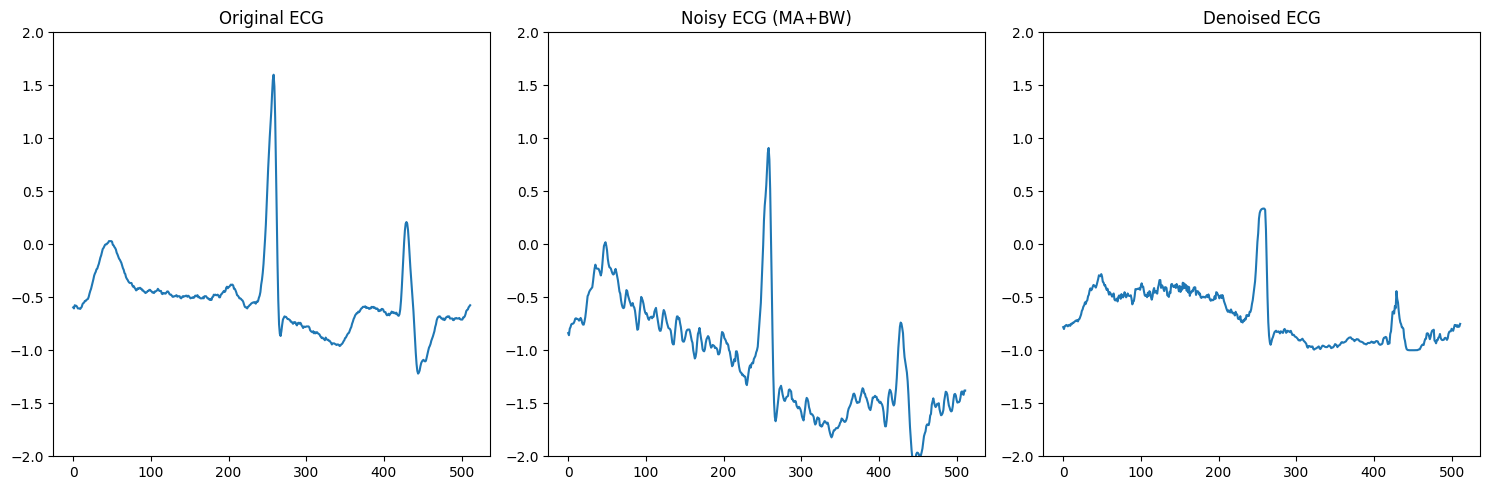

114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


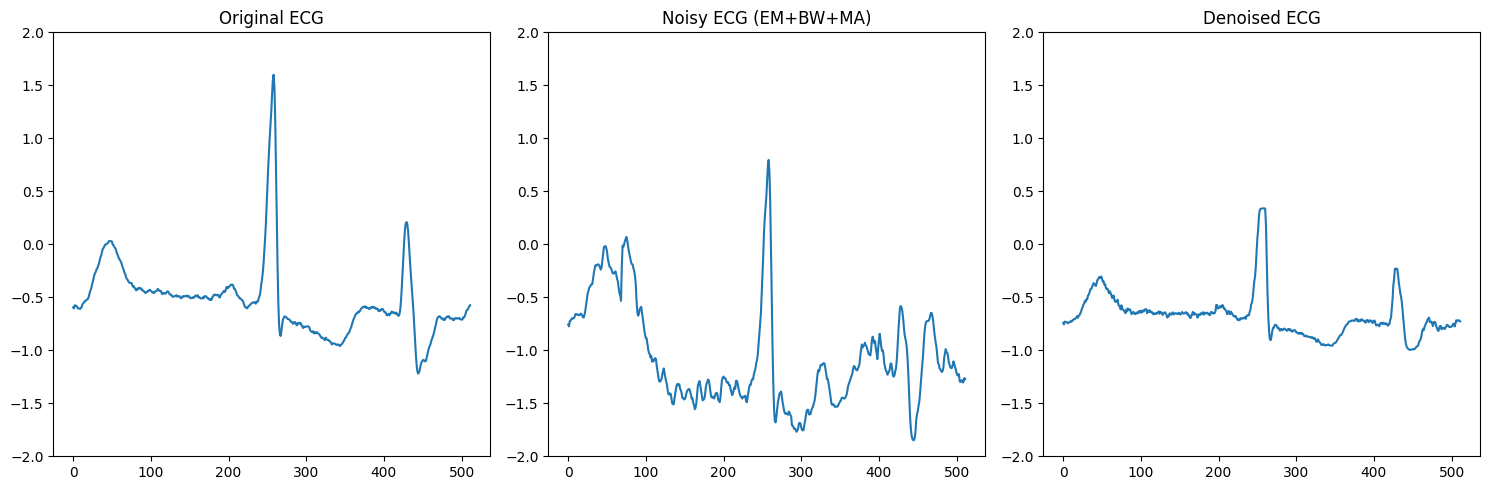

Overall Accuracy: 0.9965
Overall RMSE: 0.3711


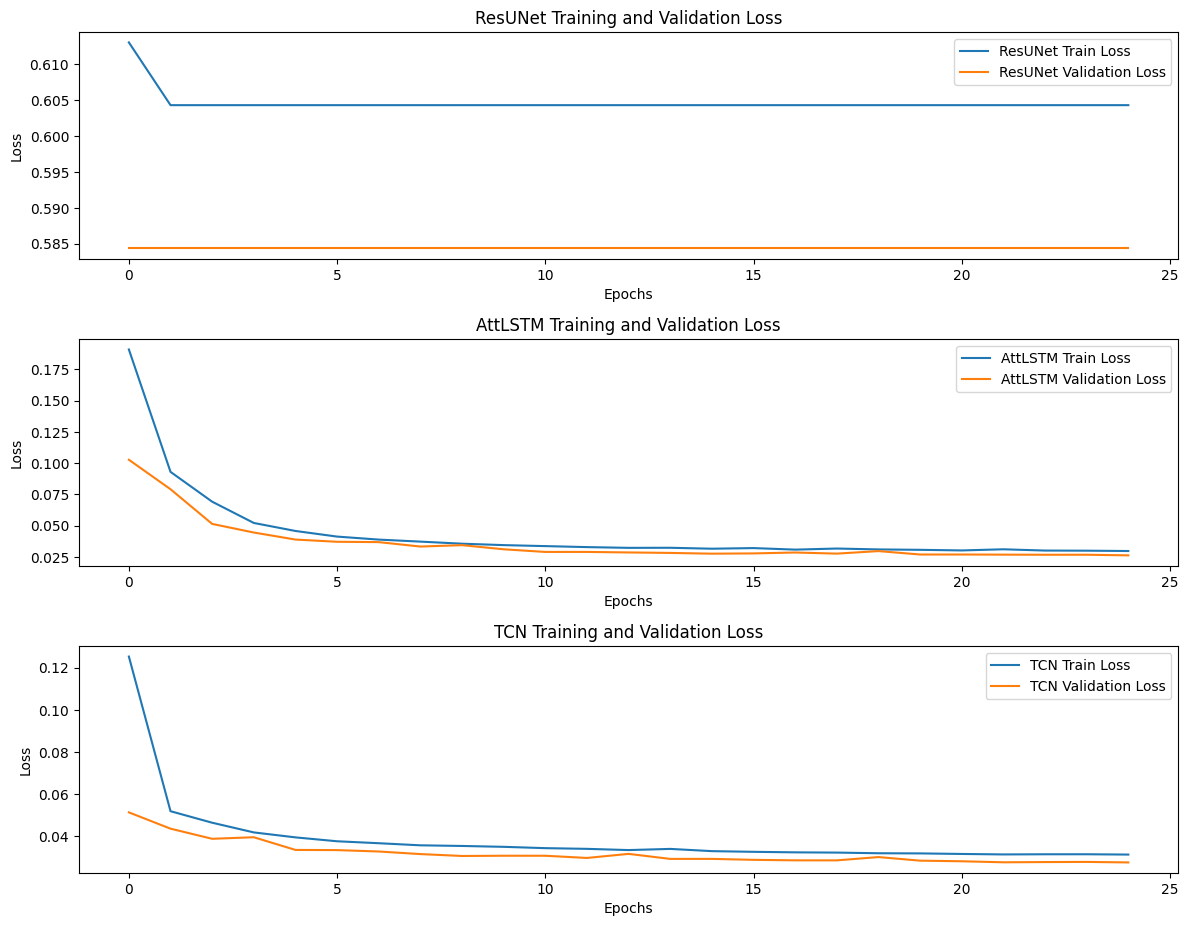

In [4]:
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LSTM, Dense, Input, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Residual Block for ResUNet
# Residual Block for ResUNet with 1x1 convolution to match dimensions
def residual_block(x, filters, kernel_size=3):
    res = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    res = Conv1D(filters, kernel_size, padding='same')(res)
    
    # 1x1 convolution to match dimensions
    shortcut = Conv1D(filters, 1, padding='same')(x)
    
    res = Add()([shortcut, res])
    return res

# ResUNet model
def build_resunet(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    e1 = residual_block(inp, 64)
    e2 = residual_block(e1, 128)
    e3 = residual_block(e2, 256)

    # Bottleneck
    bottleneck = residual_block(e3, 512)

    # Decoder
    d1 = Conv1DTranspose(256, 15, padding='same', activation='relu')(bottleneck)
    d2 = Conv1DTranspose(128, 15, padding='same', activation='relu')(d1)
    d3 = Conv1DTranspose(64, 15, padding='same', activation='relu')(d2)

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(d3)

    return Model(inp, out)

# Attention mechanism for AttLSTM
def attention_block(inputs):
    input_dim = int(inputs.shape[2])
    attention_probs = Dense(input_dim, activation='softmax', name='attention_probs')(inputs)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# AttLSTM model
def build_att_lstm(input_shape=(512, 1)):
    inp = Input(shape=input_shape)
    lstm_out = LSTM(128, return_sequences=True)(inp)
    att_out = attention_block(lstm_out)
    out = Dense(1, activation='tanh')(att_out)
    return Model(inp, out)

# TCN block
def temporal_block(x, n_filters, kernel_size, dilation_rate):
    conv1 = Conv1D(filters=n_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    conv2 = Conv1D(filters=n_filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    res = Add()([conv2, x])
    return res

# TCN model
def build_tcn(input_shape=(512, 1), n_blocks=4, n_filters=64, kernel_size=3):
    inp = Input(shape=input_shape)
    x = inp
    for i in range(n_blocks):
        x = temporal_block(x, n_filters, kernel_size, dilation_rate=2**i)
    out = Conv1D(1, 1, activation='tanh')(x)
    return Model(inp, out)

# Ensemble method: weighted averaging of predictions from all models
def ensemble_predict(models, noisy_signal):
    predictions = [model.predict(noisy_signal) for model in models]
    weights = [0.33, 0.33, 0.34]  # Adjust weights if necessary
    ensemble_prediction = np.average(predictions, axis=0, weights=weights)
    return ensemble_prediction.squeeze()

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the MIT-BIH Noise Stress Test Database
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Extend noise signal to match the target length
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

# Calculate SNR between the signal and noise
def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Calculate RMSE between the signal and denoised signal
def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Add combined noise to ECG segments
def add_combined_noise(ecg_segments, noises, target_snr_db):
    noisy_segments = []
    combined_noise_signal = sum(extend_noise_signal(noise, ecg_segments.shape[1]) for noise in noises)
    
    for ecg_segment in ecg_segments:
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(combined_noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = combined_noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function using the ensemble model
def denoise_signal(models, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = ensemble_predict(models, noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # Using approximation coefficients at the highest level

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight='balanced')
    clf.fit(features, labels)
    return clf

# Main workflow
snr_db = 0  # Example SNR value

# Load data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1
ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(ecg_segments, mapped_labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Prepare training data
noisy_ecg_slices_train = add_combined_noise(X_train, [em_noise, bw_noise, ma_noise], snr_db)
noisy_ecg_slices_val = add_combined_noise(X_val, [em_noise, bw_noise, ma_noise], snr_db)

# Instantiate advanced models
models = [
    build_resunet(),
    build_att_lstm(),
    build_tcn()
]

# Expand dimensions for training
noisy_ecg_slices_train_expanded = np.expand_dims(noisy_ecg_slices_train, axis=-1)
noisy_ecg_slices_val_expanded = np.expand_dims(noisy_ecg_slices_val, axis=-1)
clean_ecg_segments_val_expanded = np.expand_dims(X_val, axis=-1)

# Train each model
history = []
for model in models:
    model.compile(optimizer=Adam(), loss='mse')
    hist = model.fit(noisy_ecg_slices_train_expanded, np.expand_dims(X_train, axis=-1), 
                     epochs=25, batch_size=32, validation_data=(noisy_ecg_slices_val_expanded, clean_ecg_segments_val_expanded))
    history.append(hist.history)

# Dictionary to hold the noise data and names for evaluation
noises_dict = {
    'EM': [em_noise],
    'BW': [bw_noise],
    'MA': [ma_noise],
    'EM+MA': [em_noise, ma_noise],
    'EM+BW': [em_noise, bw_noise],
    'MA+BW': [ma_noise, bw_noise],
    'EM+BW+MA': [em_noise, bw_noise, ma_noise]
}

# Evaluate models
results = {}
snr_values_all = []
rmse_values_all = []

for noise_name, noise_data in noises_dict.items():
    noisy_ecg_slices_test = add_combined_noise(X_test, noise_data, snr_db)
    denoised_ecg_slices_test = denoise_signal(models, noisy_ecg_slices_test)

    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(X_test, denoised_ecg_slices_test)]
    snr_values_all.extend(snr_values)
    rmse_values_all.extend(rmse_values)

    # Extract features and classify
    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices_test])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices_test])

    model_noisy = classify_heartbeats(features_noisy, y_test)
    model_denoised = classify_heartbeats(features_denoised, y_test)

    # Predict and evaluate
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)

    # Evaluate accuracy for each class
    report_noisy = classification_report(y_test, predictions_noisy, target_names=['N', 'V', 'A', 'L'], output_dict=True, zero_division=0)
    report_denoised = classification_report(y_test, predictions_denoised, target_names=['N', 'V', 'A', 'L'], output_dict=True, zero_division=0)

    results[noise_name] = {
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values),
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in ['N', 'V', 'A', 'L']},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in ['N', 'V', 'A', 'L']},
    }

    # Plotting for the current noise type
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(X_test[0], label='Original ECG')
    plt.title('Original ECG')
    plt.ylim([-2, 2])
    
    plt.subplot(1, 3, 2)
    plt.plot(noisy_ecg_slices_test[0], label=f'Noisy ECG ({noise_name})')
    plt.title(f'Noisy ECG ({noise_name})')
    plt.ylim([-2, 2])
    
    plt.subplot(1, 3, 3)
    plt.plot(denoised_ecg_slices_test[0], label='Denoised ECG')
    plt.title('Denoised ECG')
    plt.ylim([-2, 2])
    
    plt.tight_layout()
    plt.show()

# Overall metrics
overall_accuracy = np.mean([metrics['denoised']['N'] for metrics in results.values()])
overall_rmse = np.mean(rmse_values_all)

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")

# Plot training and validation loss separately for each model
plt.figure(figsize=(12, 12))
model_names = ['ResUNet', 'AttLSTM', 'TCN']
for i, model_name in enumerate(model_names):
    plt.subplot(4, 1, i + 1)
    plt.plot(history[i]['loss'], label=f'{model_name} Train Loss')
    plt.plot(history[i]['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Output the final results with accuracy in percentage form
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    # print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy * 100:.2f}%")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy * 100:.2f}%")
    print("\n")


Noise type: EM
Average RMSE after denoising: 0.3596
Noisy data accuracies:
  N: 99.83%
  V: 65.78%
  A: 12.31%
  L: 93.50%
Denoised data accuracies:
  N: 99.63%
  V: 74.25%
  A: 10.64%
  L: 81.20%


Noise type: BW
Average RMSE after denoising: 0.3420
Noisy data accuracies:
  N: 99.86%
  V: 72.51%
  A: 8.42%
  L: 93.85%
Denoised data accuracies:
  N: 99.51%
  V: 55.29%
  A: 7.17%
  L: 90.66%


Noise type: MA
Average RMSE after denoising: 0.6094
Noisy data accuracies:
  N: 99.83%
  V: 73.94%
  A: 8.21%
  L: 93.01%
Denoised data accuracies:
  N: 99.61%
  V: 55.24%
  A: 6.50%
  L: 86.40%


Noise type: EM+MA
Average RMSE after denoising: 0.3631
Noisy data accuracies:
  N: 99.83%
  V: 65.78%
  A: 12.31%
  L: 93.50%
Denoised data accuracies:
  N: 99.75%
  V: 77.16%
  A: 5.12%
  L: 86.29%


Noise type: EM+BW
Average RMSE after denoising: 0.3011
Noisy data accuracies:
  N: 99.80%
  V: 70.29%
  A: 9.41%
  L: 89.38%
Denoised data accuracies:
  N: 99.68%
  V: 54.76%
  A: 7.18%
  L: 83.66%


Noise 

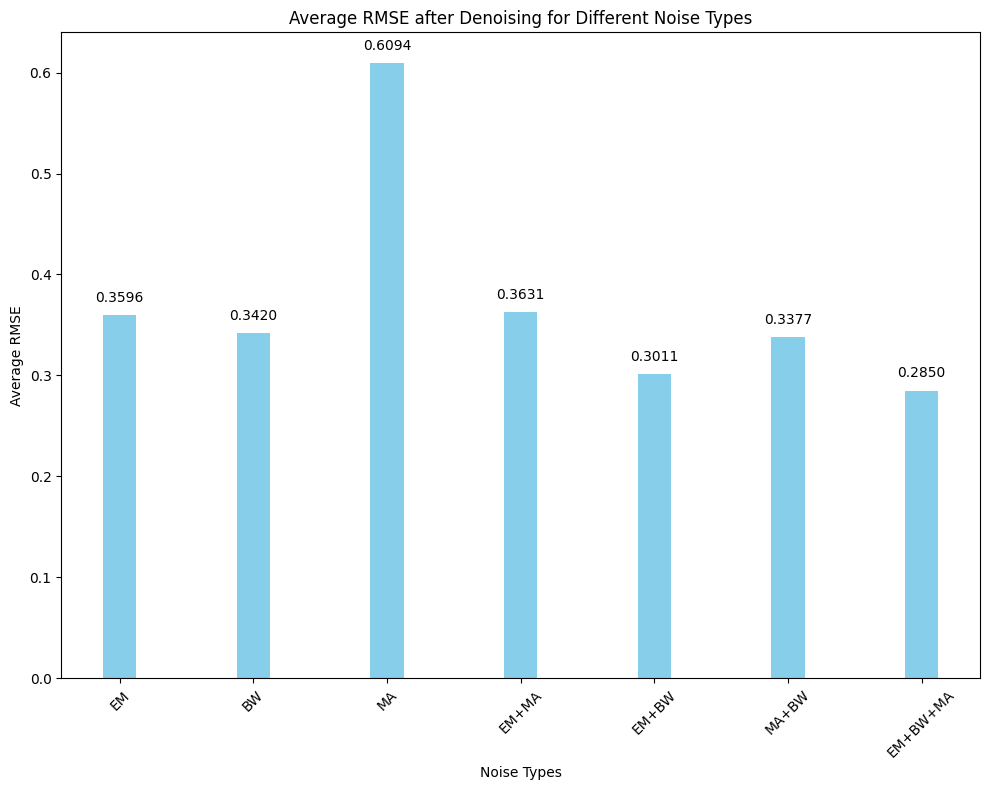

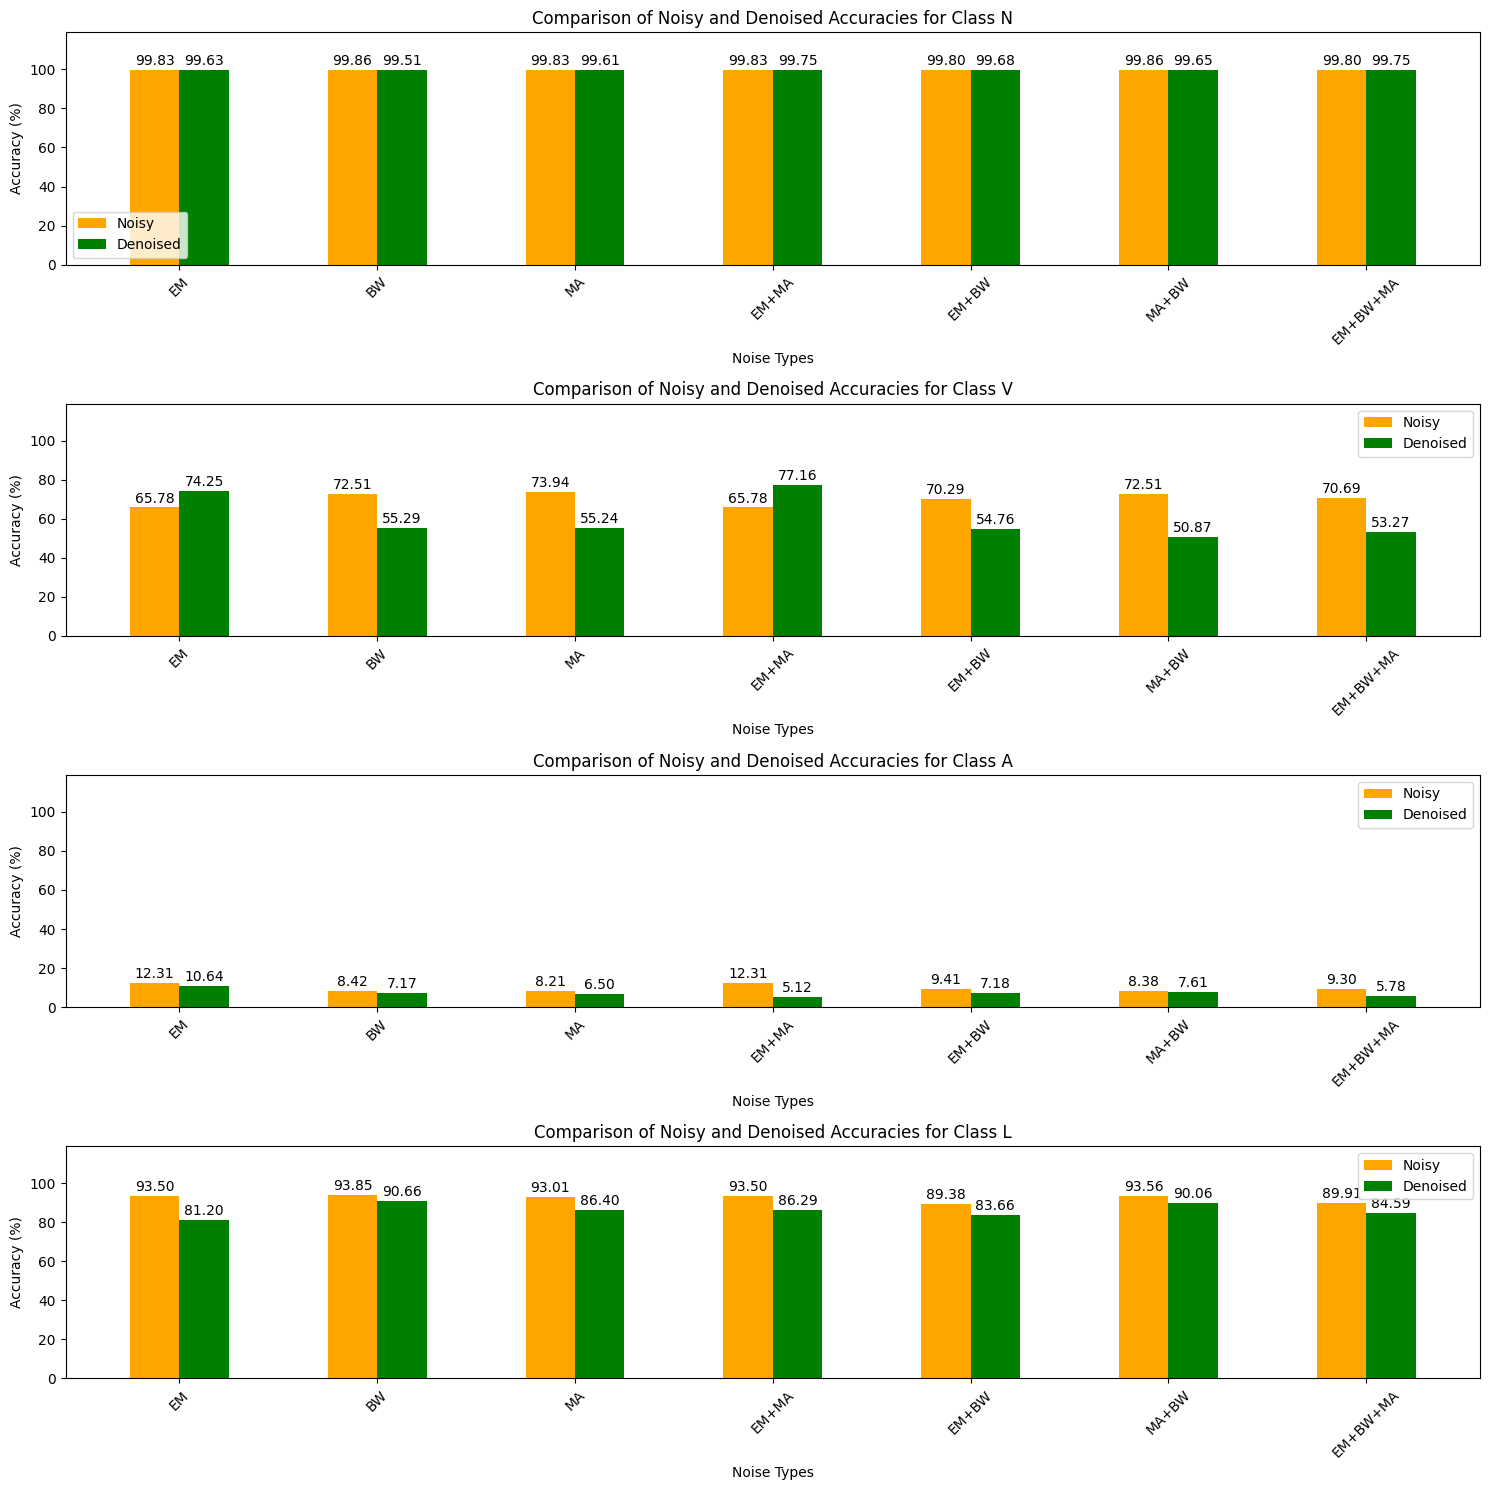

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation for plotting
noise_names = list(results.keys())
class_labels = list(results[noise_names[0]]['noisy'].keys())

noisy_accuracies = {class_label: [] for class_label in class_labels}
denoised_accuracies = {class_label: [] for class_label in class_labels}

for noise_name, metrics in results.items():
    for class_label in class_labels:
        noisy_accuracies[class_label].append(metrics['noisy'][class_label] * 100)  # Convert to percentage
        denoised_accuracies[class_label].append(metrics['denoised'][class_label] * 100)  # Convert to percentage


bar_width = 0.25  # Width of the bars
# Plotting comparison bar graphs for Noisy and Denoised Accuracies
plt.figure(figsize=(10, 8))
bars = plt.bar(noise_names, rmse_values, bar_width, color='skyblue')
plt.title('Average RMSE after Denoising for Different Noise Types')
plt.xlabel('Noise Types')
plt.ylabel('Average RMSE')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding text labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

plt.figure(figsize=(15, 15))

for i, class_label in enumerate(class_labels):
    plt.subplot(len(class_labels), 1, i + 1)
    noisy_bars = plt.bar(index, noisy_accuracies[class_label], bar_width, label='Noisy', color='orange')
    denoised_bars = plt.bar(index + bar_width, denoised_accuracies[class_label], bar_width, label='Denoised', color='green')
    
    plt.title(f'Comparison of Noisy and Denoised Accuracies for Class {class_label}')
    plt.xlabel('Noise Types')
    plt.ylabel('Accuracy (%)')
    plt.xticks(index + bar_width / 2, noise_names, rotation=45)
    plt.ylim([0, 119])
    plt.legend()

     # Display values over each bar
    for bar in noisy_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom')
        
    for bar in denoised_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom')


plt.tight_layout()
plt.show()


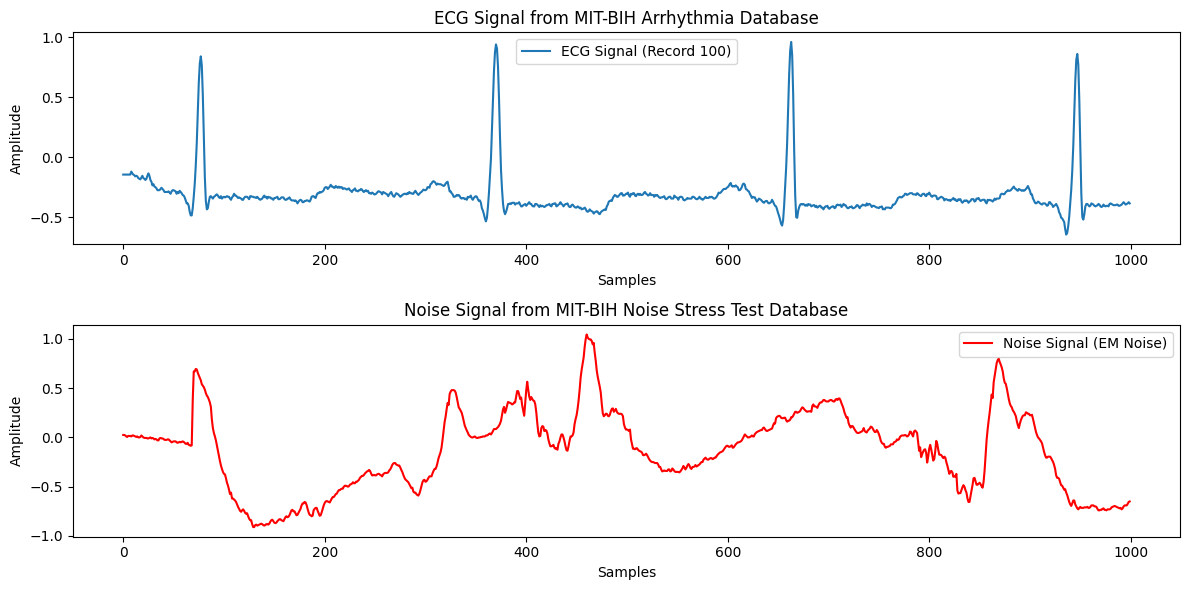

In [40]:
import wfdb
import matplotlib.pyplot as plt

# Define the paths to the records
arrhythmia_record_path = 'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/100'
noise_record_path = 'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0/em'

# Load the ECG signal
ecg_record = wfdb.rdrecord(arrhythmia_record_path)
ecg_signal = ecg_record.p_signal[:, 0]  # Using the first lead

# Load the noise signal
noise_record = wfdb.rdrecord(noise_record_path)
noise_signal = noise_record.p_signal[:, 0]

# Plot the ECG and noise signals
plt.figure(figsize=(12, 6))

# Plot ECG signal
plt.subplot(2, 1, 1)
plt.plot(ecg_signal[:1000], label='ECG Signal (Record 100)')
plt.title('ECG Signal from MIT-BIH Arrhythmia Database')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

# Plot Noise signal
plt.subplot(2, 1, 2)
plt.plot(noise_signal[:1000], label='Noise Signal (EM Noise)', color='red')
plt.title('Noise Signal from MIT-BIH Noise Stress Test Database')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
